In [40]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import shutil

from hloc import (
    extract_features,
    match_features,
    match_dense,
    reconstruction,
    visualization,
    pairs_from_all,
    localize_sfm,
    pairs_from_exhaustive
)

ROOT = Path().absolute()
# add root to path in order to execute scripts
if str(ROOT) not in sys.path:
  sys.path.append(str(ROOT))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
DATASET = Path("datasets/framlingham2")

IMAGES = DATASET / "images"
QI = "query/MAIN.png" # img that will be localized
QUERY_IMAGE_PATH = IMAGES / QI

OUT = Path("outputs/sfm/")
SFM_PAIRS = OUT / "pairs.txt"
SFM_DIR = OUT / "framlingham2-loctest"

# retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["superpoint_max"]
matcher_conf = match_features.confs["superpoint+lightglue"]
# matcher_conf = match_dense.confs["loftr"]

In [42]:
pairs_from_all.main(SFM_PAIRS, IMAGES, recursive=False)

[2024/06/05 20:16:04 hloc.utils.parsers INFO] Imported 10 images from images
[2024/06/05 20:16:04 hloc INFO] Found 45 pairs.


[PosixPath('datasets/framlingham2/images/7Cam1.png'), PosixPath('datasets/framlingham2/images/7Cam10.png'), PosixPath('datasets/framlingham2/images/7Cam2.png'), PosixPath('datasets/framlingham2/images/7Cam3.png'), PosixPath('datasets/framlingham2/images/7Cam4.png'), PosixPath('datasets/framlingham2/images/7Cam5.png'), PosixPath('datasets/framlingham2/images/7Cam6.png'), PosixPath('datasets/framlingham2/images/7Cam7.png'), PosixPath('datasets/framlingham2/images/7Cam8.png'), PosixPath('datasets/framlingham2/images/7Cam9.png')]


In [43]:
feature_path = extract_features.main(feature_conf, IMAGES, OUT)
#feature_path = Path(outputs, feature_conf["output"] + ".h5")

[2024/06/05 20:16:04 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}
[2024/06/05 20:16:04 hloc INFO] Found 11 images in root datasets/framlingham2/images.


Loaded SuperPoint model


  0%|          | 0/11 [00:00<?, ?it/s]

dict_keys(['image'])


 18%|█▊        | 2/11 [00:00<00:02,  3.52it/s]

dict_keys(['image'])
dict_keys(['image'])


 36%|███▋      | 4/11 [00:01<00:01,  4.28it/s]

dict_keys(['image'])


 45%|████▌     | 5/11 [00:01<00:01,  4.50it/s]

dict_keys(['image'])
dict_keys(['image'])


 64%|██████▎   | 7/11 [00:01<00:00,  4.90it/s]

dict_keys(['image'])


 73%|███████▎  | 8/11 [00:01<00:00,  4.39it/s]

dict_keys(['image'])


 82%|████████▏ | 9/11 [00:02<00:00,  4.52it/s]

dict_keys(['image'])


 91%|█████████ | 10/11 [00:02<00:00,  4.41it/s]

dict_keys(['image'])
dict_keys(['image'])


100%|██████████| 11/11 [00:02<00:00,  4.48it/s]
[2024/06/05 20:16:06 hloc INFO] Finished exporting features.


In [44]:
print(feature_path)

match_path = match_features.main(
    conf=matcher_conf,
    pairs=SFM_PAIRS,
    features=feature_conf["output"],
    export_dir=OUT,
)

"""
feature_path, match_path = match_dense.main(
  conf=matcher_conf, 
  pairs=sfm_pairs, 
  image_dir=images, 
  export_dir=outputs,
  features_ref=feature_path
)
"""

[2024/06/05 20:16:06 hloc INFO] Matching local features with configuration:
{'model': {'features': 'superpoint', 'name': 'lightglue'},
 'output': 'matches-superpoint-lightglue'}


outputs/sfm/feats-superpoint-n4096-rmax1600.h5


  0%|          | 0/45 [00:00<?, ?it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


  2%|▏         | 1/45 [00:00<00:18,  2.40it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


  4%|▍         | 2/45 [00:00<00:14,  3.06it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


  7%|▋         | 3/45 [00:00<00:13,  3.19it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


  9%|▉         | 4/45 [00:01<00:13,  2.99it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 11%|█         | 5/45 [00:01<00:13,  2.94it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 16%|█▌        | 7/45 [00:02<00:12,  3.10it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])
dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 18%|█▊        | 8/45 [00:02<00:10,  3.38it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 20%|██        | 9/45 [00:02<00:10,  3.45it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 22%|██▏       | 10/45 [00:03<00:10,  3.30it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 24%|██▍       | 11/45 [00:03<00:10,  3.30it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 27%|██▋       | 12/45 [00:03<00:10,  3.24it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 29%|██▉       | 13/45 [00:03<00:09,  3.32it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 31%|███       | 14/45 [00:04<00:09,  3.35it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 33%|███▎      | 15/45 [00:04<00:08,  3.35it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 36%|███▌      | 16/45 [00:04<00:08,  3.41it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 38%|███▊      | 17/45 [00:05<00:08,  3.43it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 40%|████      | 18/45 [00:05<00:08,  3.31it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 44%|████▍     | 20/45 [00:06<00:07,  3.43it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])
dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 47%|████▋     | 21/45 [00:06<00:06,  3.61it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 49%|████▉     | 22/45 [00:06<00:06,  3.38it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 51%|█████     | 23/45 [00:06<00:06,  3.44it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 53%|█████▎    | 24/45 [00:07<00:06,  3.49it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 56%|█████▌    | 25/45 [00:07<00:05,  3.52it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 58%|█████▊    | 26/45 [00:07<00:05,  3.46it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 60%|██████    | 27/45 [00:08<00:05,  3.43it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 62%|██████▏   | 28/45 [00:08<00:05,  3.30it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 64%|██████▍   | 29/45 [00:08<00:04,  3.36it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 67%|██████▋   | 30/45 [00:09<00:04,  3.33it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 69%|██████▉   | 31/45 [00:09<00:04,  3.24it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 71%|███████   | 32/45 [00:09<00:04,  3.11it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 73%|███████▎  | 33/45 [00:10<00:03,  3.11it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 76%|███████▌  | 34/45 [00:10<00:03,  2.97it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 78%|███████▊  | 35/45 [00:10<00:03,  3.02it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 80%|████████  | 36/45 [00:11<00:02,  3.07it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 82%|████████▏ | 37/45 [00:11<00:02,  3.05it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 84%|████████▍ | 38/45 [00:11<00:02,  3.13it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 87%|████████▋ | 39/45 [00:12<00:01,  3.17it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 89%|████████▉ | 40/45 [00:12<00:01,  3.24it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 91%|█████████ | 41/45 [00:12<00:01,  3.10it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 93%|█████████▎| 42/45 [00:13<00:00,  3.08it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 96%|█████████▌| 43/45 [00:13<00:00,  3.01it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 98%|█████████▊| 44/45 [00:13<00:00,  2.96it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


100%|██████████| 45/45 [00:14<00:00,  3.14it/s]
[2024/06/05 20:16:21 hloc INFO] Finished exporting matches.


'\nfeature_path, match_path = match_dense.main(\n  conf=matcher_conf, \n  pairs=sfm_pairs, \n  image_dir=images, \n  export_dir=outputs,\n  features_ref=feature_path\n)\n'

## 3D reconstruction
Run COLMAP on the features and matches.

In [45]:
model = reconstruction.main(SFM_DIR, IMAGES, SFM_PAIRS, feature_path, match_path)

[2024/06/05 20:16:21 hloc INFO] Creating an empty database...
[2024/06/05 20:16:22 hloc INFO] Importing images into the database...
[2024/06/05 20:16:23 hloc INFO] Importing features into the database...
100%|██████████| 11/11 [00:00<00:00, 173.50it/s]
[2024/06/05 20:16:24 hloc INFO] Importing matches into the database...
100%|██████████| 45/45 [00:00<00:00, 193.23it/s]
[2024/06/05 20:16:24 hloc INFO] Performing geometric verification of the matches...
I20240605 20:16:24.773192 27438 misc.cc:198] 
Custom feature matching
I20240605 20:16:24.780902 27438 feature_matching.cc:1021] Matching block [1/1]
I20240605 20:16:26.207993 27438 feature_matching.cc:46]  in 1.427s
I20240605 20:16:26.232614 27438 timer.cc:91] Elapsed time: 0.024 [minutes]
[2024/06/05 20:16:26 hloc INFO] Running 3D reconstruction...
I20240605 20:16:26.321628 27449 misc.cc:198] 
Loading database
I20240605 20:16:26.352939 27449 database_cache.cc:54] Loading cameras...
I20240605 20:16:26.353940 27449 database_cache.cc:64]  

[2024/06/05 20:16:31 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}


Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

dict_keys(['image'])


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]
[2024/06/05 20:16:32 hloc INFO] Finished exporting features.
[2024/06/05 20:16:32 hloc INFO] Found 10 pairs.
[2024/06/05 20:16:32 hloc INFO] Matching local features with configuration:
{'model': {'features': 'superpoint', 'name': 'lightglue'},
 'output': 'matches-superpoint-lightglue'}
  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 10%|█         | 1/10 [00:00<00:04,  2.24it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 20%|██        | 2/10 [00:00<00:02,  2.73it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 30%|███       | 3/10 [00:01<00:02,  2.60it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 40%|████      | 4/10 [00:01<00:02,  2.45it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 50%|█████     | 5/10 [00:02<00:02,  2.43it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 60%|██████    | 6/10 [00:02<00:01,  2.29it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 70%|███████   | 7/10 [00:03<00:01,  2.27it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 80%|████████  | 8/10 [00:03<00:00,  2.23it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


 90%|█████████ | 9/10 [00:03<00:00,  2.34it/s]

dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])


100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
[2024/06/05 20:16:36 hloc INFO] Finished exporting matches.


found 374/513 inlier correspondences.


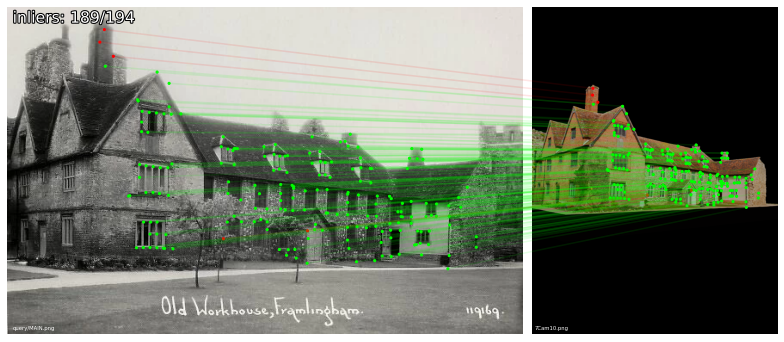

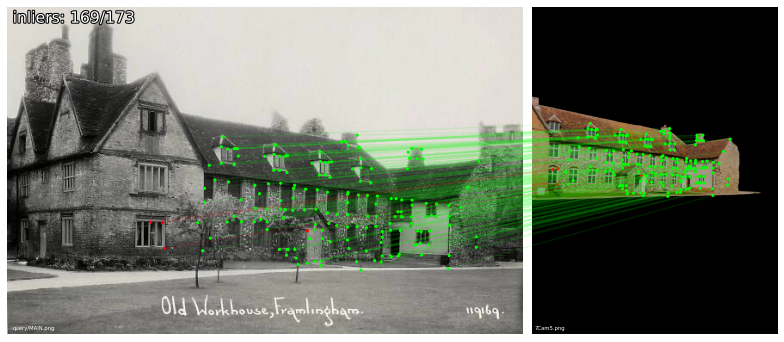

In [46]:
"""
localize_sfm.main(
    sfm_dir,
    dataset / "queries/*_time_queries_with_intrinsics.txt",
    loc_pairs,
    features,
    loc_matches,
    results,
    covisibility_clustering=False,
)  # not required with SuperPoint+SuperGlue
"""

# https://colab.research.google.com/drive/1MrVs9b8aQYODtOGkoaGNF9Nji3sbCNMQ#scrollTo=74f07f86

# register new QUERY_IMAGE
references_registered = [model.images[i].name for i in model.reg_image_ids()]
extract_features.main(
    feature_conf,
    IMAGES,
    image_list=[QI],
    feature_path=feature_path,
    overwrite=True,
)
pairs_from_exhaustive.main(
    SFM_PAIRS, image_list=[QI], ref_list=references_registered
)
match_features.main(
    matcher_conf, SFM_PAIRS, features=feature_path, matches=match_path, overwrite=True
)

import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(IMAGES / QI)
ref_ids = [model.find_image_with_name(n).image_id for n in references_registered]
conf = {
    "estimation": {"ransac": {"max_error": 12}},
    "refinement": {"refine_focal_length": True, "refine_extra_params": True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(
    localizer, QI, camera, ref_ids, feature_path, match_path
)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(IMAGES, QI, log, model)

In [47]:
from hloc.utils import viz_3d
import numpy as np
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

In [48]:
pose = pycolmap.Image(cam_from_world=ret['cam_from_world'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=QI, fill=True)
# visualize 2D-3D correspodences
inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inliers']]])
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=QI)
fig.show()

In [49]:
# extract localized camera
camera_instance = ret["cam_from_world"]
print(dir(ret["camera"]))
camera_params = ret["camera"].params
print(dir(camera_instance))

class TempImage:
    def __init__(self, qvec, tvec, name, point3d_ids=None):
        self.qvec = np.array(qvec)
        self.tvec = np.array(tvec)
        self.name = name
        if point3d_ids:
            self.point3D_ids = point3d_ids

    def todict(self):
        return {
            "qvec": self.qvec,
            "tvec": self.tvec,
            "name": self.name,
        }


localized_camera = TempImage(
    camera_instance.rotation.todict()["quat"], 
    camera_instance.translation, 
    QI,
    None #[i if e else -1 for i, e in enumerate(ret["inliers"])]
)

# transform to match coordinate system rotation and location
transform1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
transform2 = np.array([[-1, 0, 0, 0], [0, 0, -1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
print(camera_instance.matrix())

['__class__', '__copy__', '__deepcopy__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'calibration_matrix', 'cam_from_img', 'cam_from_img_threshold', 'camera_id', 'create', 'extra_params_idxs', 'focal_length', 'focal_length_idxs', 'focal_length_x', 'focal_length_y', 'has_bogus_params', 'has_prior_focal_length', 'height', 'img_from_cam', 'mean_focal_length', 'mergedict', 'model', 'params', 'params_info', 'params_to_string', 'principal_point_idxs', 'principal_point_x', 'principal_point_y', 'rescale', 'set_params_from_string', 'summary', 'todict', 'verify_params', 'width']
['__class__', '__copy__', '__deepcopy__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__'

In [50]:
from third_party.Neuralangelo.convert_data_to_json import data_to_json

args = {
  "data_dir": str(SFM_DIR.absolute()),
  "scene_type": "outdoor",
  "image_dir": str(IMAGES.absolute()),
  "extra_cam": localized_camera
}

data_to_json(args)

SFM_IMAGES = SFM_DIR / "images"
if not SFM_IMAGES.exists():
  # copy files from input images to self contained project path
  # os.mkdir(new_input_path)
  print("copied input images to self contained SfM reconstruction folder")
  shutil.copytree(IMAGES, SFM_IMAGES)

Fraction of images looking at the center: 0.09.
Fraction of images positioned around the center: 0.64.
Valid fraction of concentric images: 0.09.
frame reprojection error for image ID 1: 0.985
frame reprojection error for image ID 2: 1.036
frame reprojection error for image ID 3: 0.978
frame reprojection error for image ID 4: 1.013
frame reprojection error for image ID 5: 1.017
frame reprojection error for image ID 6: 0.998
frame reprojection error for image ID 7: 1.007
frame reprojection error for image ID 8: 0.987
frame reprojection error for image ID 9: 1.012
frame reprojection error for image ID 10: 0.953
frame reprojection error for image ID 1337: 999999
Writing data to json file: /mnt/d/dev/python/Hierarchical-Localization/outputs/sfm/framlingham2-loctest/transforms.json
copied input images to self contained SfM reconstruction folder
